# Recurrent Neural Network

In [1]:
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import re
%matplotlib inline

## Configuration

In [2]:
batch_size = 20
embedding_size = 2
num_sampled = 15

## Movie Review Text data

In [3]:
sentences = pd.read_csv("./data/review_text.csv", header=None)
sentences = sentences.values.ravel().tolist()

## Preprocessing

In [4]:
sentences = [re.sub('[^a-z ]+',' ',x.lower()) for x in sentences]

## Sentences to words and word count

In [5]:
words = " ".join(sentences).split()
count = collections.Counter(words)

In [6]:
print ("Word count", count.most_common()[:5])

Word count [('the', 331252), ('and', 160303), ('a', 159888), ('of', 143549), ('to', 132402)]


## Build Dictionary

In [7]:
idx_to_word = {idx:w for idx, w in enumerate(count.keys())}
word_to_idx = {w: i for i, w in idx_to_word.items()} 
voc_size = len(word_to_idx)
data = [[word_to_idx[word] for word in sentence.split()] for sentence in sentences]

print('Sample data', data[0], [idx_to_word[t] for t in data[0]])

Sample data [36421, 34991, 23241, 47544, 15981, 2809, 12532, 26073, 37873, 50223, 9571, 37360, 31726, 68423, 50223, 52612, 37788, 32464, 842, 6642, 43700, 15386, 37788, 32464, 11066, 62334, 36443, 38922, 51246, 35817, 71540, 69168, 17228, 58650, 56915, 32464, 23241, 62323, 31726, 59976, 37527, 1685, 47544, 50557, 60534, 22686, 27453, 1685, 63853, 32464, 44481, 31726, 71166, 1685, 47058, 56503, 31726, 21830, 1685, 41805, 31726, 25138, 5173, 20003, 15386, 4769, 59557, 6642, 38192, 31432, 50223, 40118, 37527, 67371, 15266, 49975, 37527, 67371, 70393, 8270, 37527, 67371, 17142, 66554, 7749, 37527, 67371, 18081, 36421, 11132, 2809, 21446, 61720, 62908, 1685, 47544, 23241, 50013, 48607, 3694, 32834, 64482, 32834, 23241, 60596, 30924, 44049, 1685, 14175, 16003, 12836, 28729, 11036, 32834, 1685, 56560, 50223, 1685, 28106, 14356, 34991, 22154, 37788, 32464, 47419, 23241, 33239, 50223, 63466, 42733, 31726, 9100, 54141] ['naturally', 'in', 'a', 'film', 'who', 's', 'main', 'themes', 'are', 'of', '

## Training data: CBOW

In [8]:
cbow_pairs = []
for sentence in data:
    for i in range(1, len(sentence)-1):
        cbow_pairs.append([[sentence[i-1], sentence[i+1]], sentence[i]])
print("CBOW pairs :" , cbow_pairs[:10])

CBOW pairs : [[[36421, 23241], 34991], [[34991, 47544], 23241], [[23241, 15981], 47544], [[47544, 2809], 15981], [[15981, 12532], 2809], [[2809, 26073], 12532], [[12532, 37873], 26073], [[26073, 50223], 37873], [[37873, 9571], 50223], [[50223, 37360], 9571]]


## Training data: Skip gram

In [9]:
skip_gram_pairs = []
for sentence in data:
    for i in range(1, len(sentence)-1):
        skip_gram_pairs.append([sentence[i], sentence[i-1]])
        skip_gram_pairs.append([sentence[i], sentence[i+1]])
print("Skip gram pairs :" , skip_gram_pairs[:10])

Skip gram pairs : [[34991, 36421], [34991, 23241], [23241, 34991], [23241, 47544], [47544, 23241], [47544, 15981], [15981, 47544], [15981, 2809], [2809, 15981], [2809, 12532]]


## Generate Batch

In [10]:
def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data=[]
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

In [11]:
print ('Batches (x, y)', generate_batch(3))

Batches (x, y) ([4494, 22247, 51855], [[29633], [50167], [31726]])


## Input, Label Variable 만들기

In [12]:
# Input data
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [13]:
# Look up embeddings for inputs.
embeddings = tf.Variable(
    tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

In [14]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

## loss function과 optimizer

In [15]:
loss = tf.reduce_mean(
  tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

In [16]:
loss_trn = list()
with tf.Session() as sess:
    # Initializing all variables
    sess.run(tf.initialize_all_variables())

    for step in range(200):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        loss_trn.append(loss_val)
        if step % 10 == 0:
            print("Loss at ", step, loss_val) # Report the loss

    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = sess.run(embeddings)

Loss at  0 81.5753
Loss at  10 80.3171
Loss at  20 77.0485
Loss at  30 76.4306
Loss at  40 88.266
Loss at  50 72.395
Loss at  60 73.5544
Loss at  70 60.7777
Loss at  80 60.3849
Loss at  90 59.1671
Loss at  100 77.3924
Loss at  110 70.7755
Loss at  120 57.8257
Loss at  130 67.0192
Loss at  140 93.3969
Loss at  150 70.3723
Loss at  160 47.5134
Loss at  170 84.9768
Loss at  180 79.7238
Loss at  190 63.7816


## Training loss plot

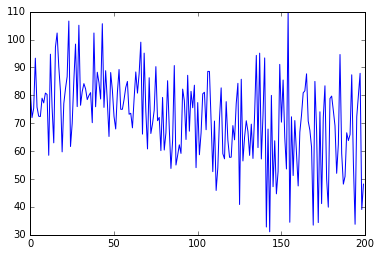

In [17]:
plt.plot(loss_trn)

## Distributed Representations of words

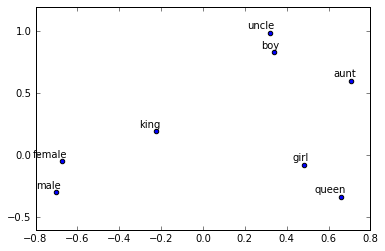

In [18]:
labels = ["queen", "king", "boy", "girl", "uncle", "aunt", "female", "male"] # Show top 10 words
for i, label in enumerate(labels):
    x, y = trained_embeddings[i,:]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
        textcoords='offset points', ha='right', va='bottom')